In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
print(bmi_cfe_open)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_open.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')



initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

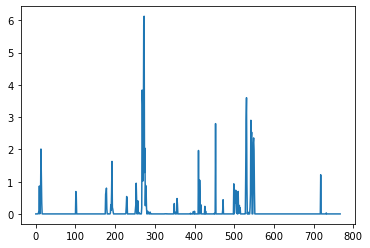

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Originial Version 
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []
cfe_def = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 
    #obs_m = (obs * 3.281**3) #converting cfs to m3/s
    #print(obs_m)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
    cfe_def.append(soil_reservoir_storage_deficit)
    print("soil res def, cfe petrub", cfe_def)
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    # if surface_runoff>0:
    #     print("surface_runoff",surface_runoff)
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    #print("mean", outflow_peturb_mean)
    #print("covar", outflow_peturb_covar)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
#     print("3 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("3 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("3 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("3 runoff: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("3 runoff: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("3 runoff: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     print("\n")
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf.update()
    
    # print("4 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    # print("4 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    # print("4 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    # print("4 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    # print("4 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    # print("4 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    # print("\n")
    
    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

#     print("5 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("5 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("5 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("5 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     print("5 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     print("5 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     print("5 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("5 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("5 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
    
   # print("\n")
    
#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    
    cfe_analysis.update() #get new streamflow value based on state var change
    
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    #surface_runoff_depth_m replaced with DIRECT_RUNOFF
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    #cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    #cfe_peturbed.update()
  
#     print("6 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("6 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("6 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("6 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     print("6 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     print("6 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     print("6 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("6 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("6 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     print("\n")
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
# # want to see runoff q adjusted. vol adjusted in GIUH 
usgs.finalize()
enkf.finalize()

soil res def, cfe petrub [0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [38.1787128]
 warning validity is zero
soil res def, cfe petrub [0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [124.95505968]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [50.49892037]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [86.27171231]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [36.91566244]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0]
Beginning----------------------------
self.f 0

soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [36.45520987]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [34.53126909]
 warn

EnKF Code predicted, X Post [18.28660477]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0
EnKF Code predicted, X Post [15.6649536]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


EnKF Code predicted, X Post [57.88295012]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

EnKF Code predicted, X Post [nan]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

EnKF Code predicted, X Post [10.25532119]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

EnKF Code predicted, X Post [29.65176893]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

EnKF Code predicted, X Post [16.30102441]
 warning validity is zero
soil res def, cfe petrub [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

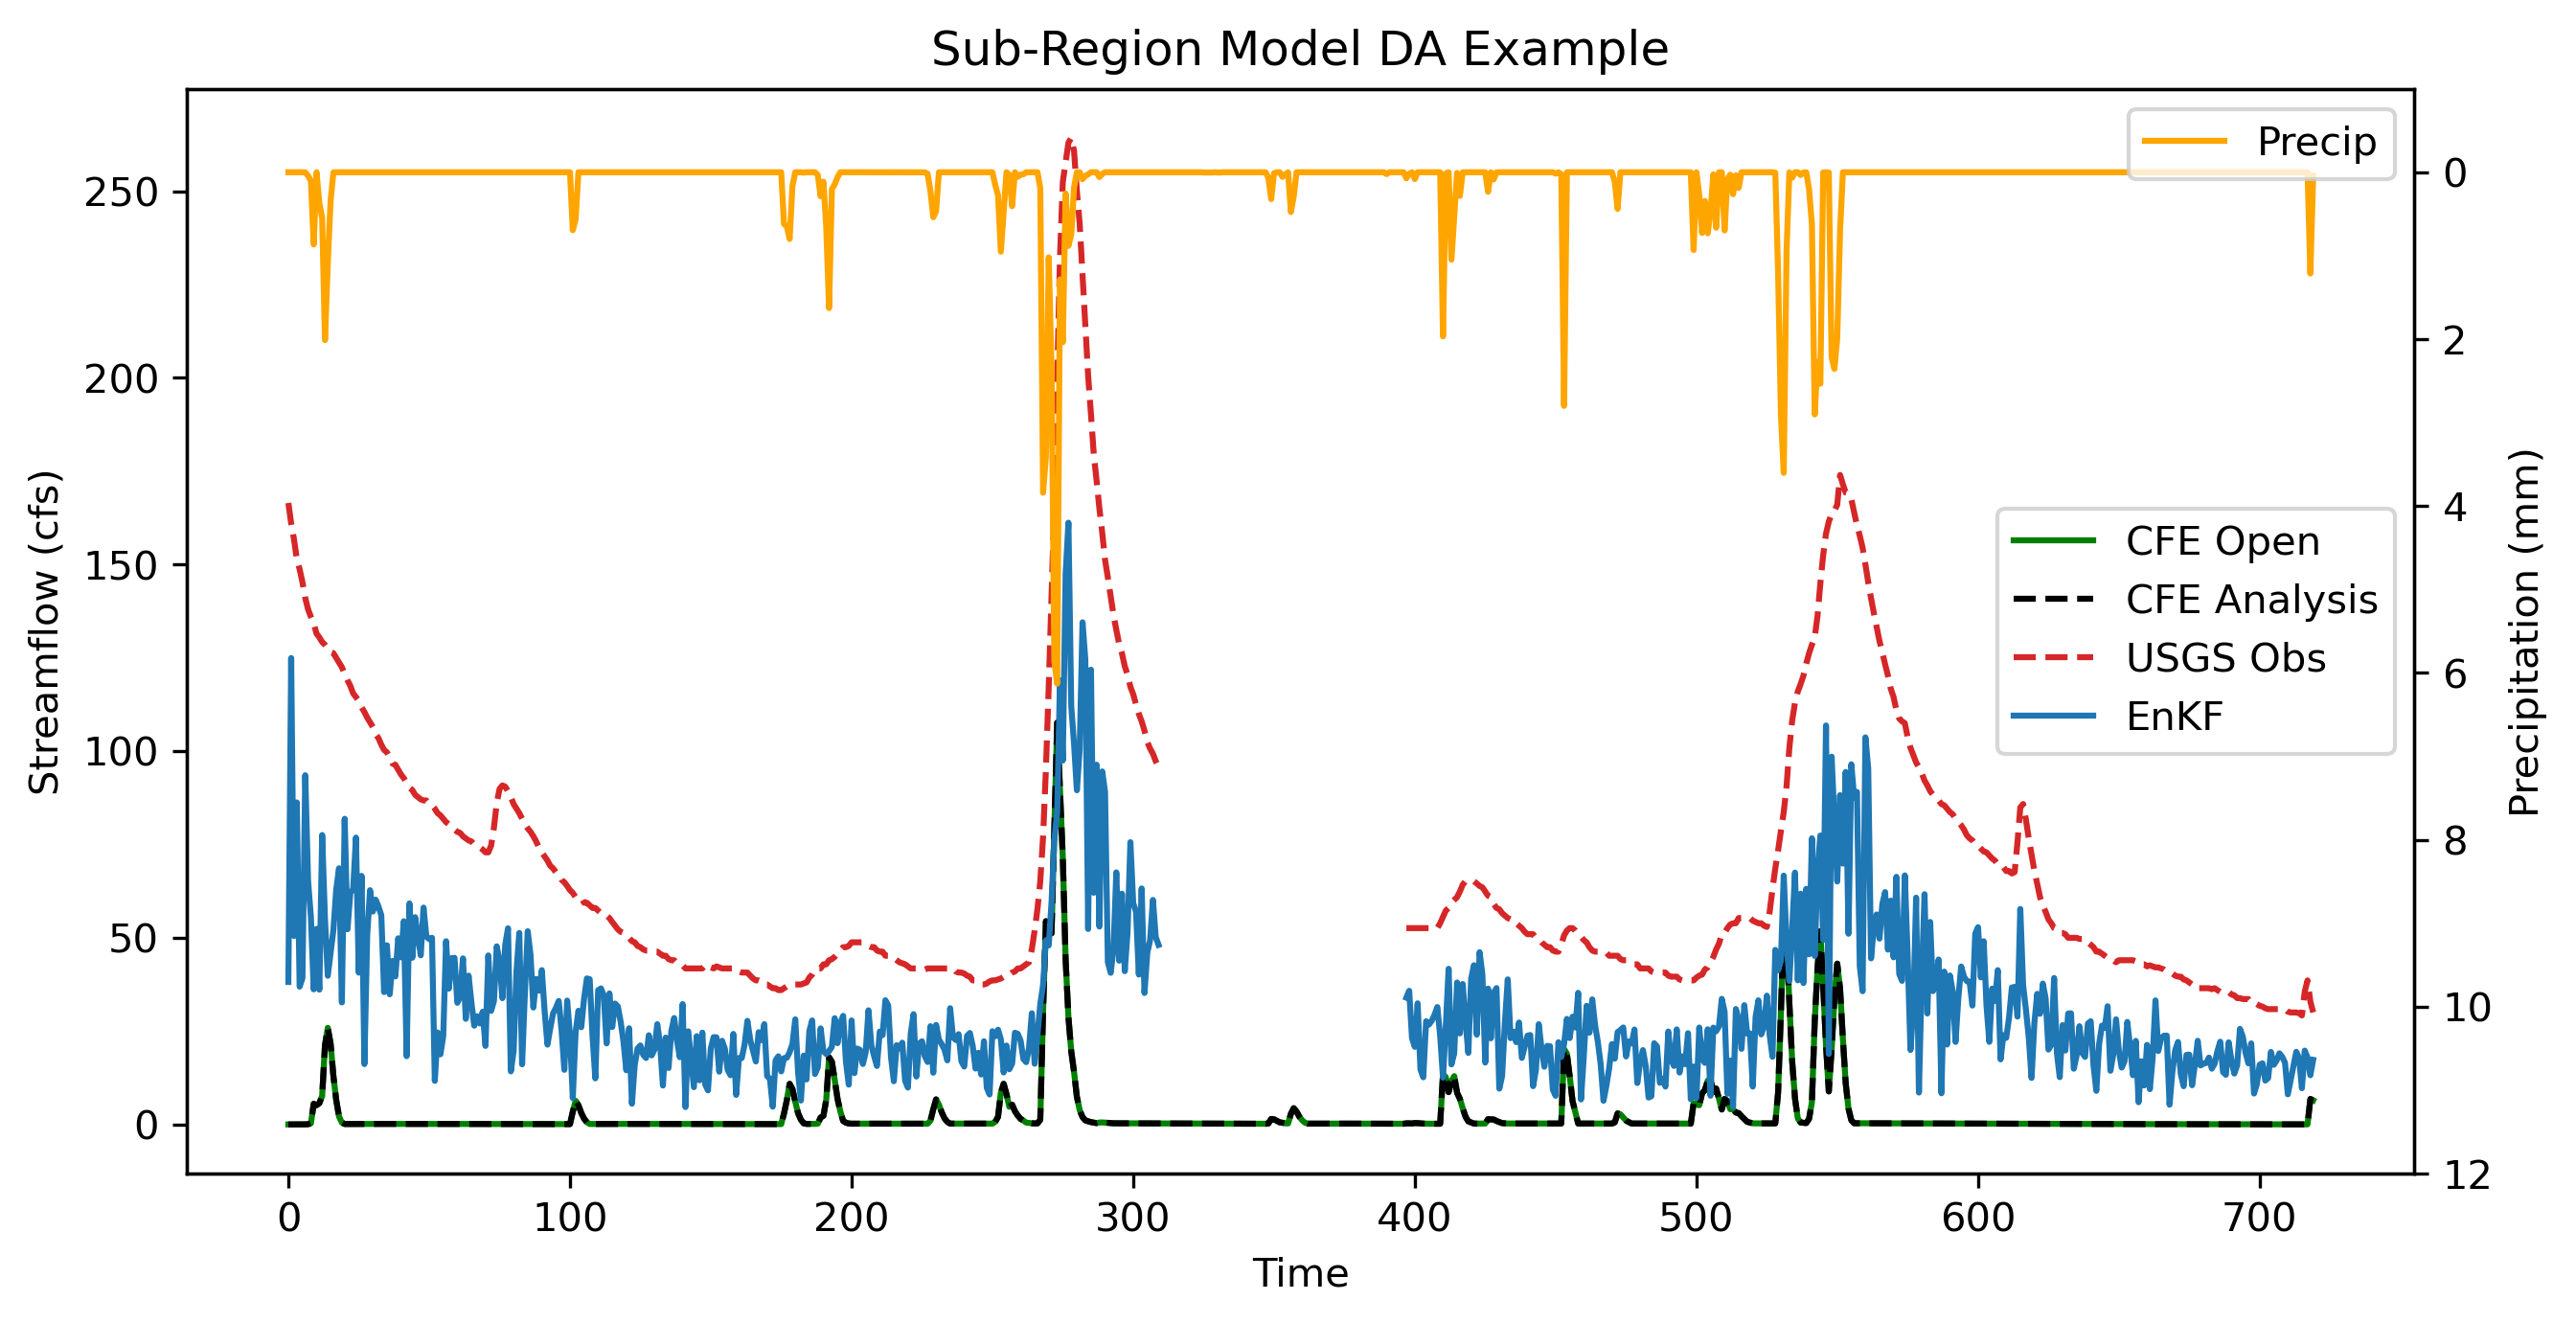

In [7]:
istart_plot=0
iend_plot=720
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(-1,12,1)
ax2.invert_yaxis()


plt.title('Sub-Region Model DA Example')
#plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
ax2.plot(df_forcing['APCP_surface'][istart_plot:iend_plot], color="orange", label = 'Precip')
#plt.ylabel('Streamflow (CFS)')
#plt.xlabel('Time')
ax1.legend(loc='center right')
ax2.legend(loc='upper right')
plt.savefig("WorkingDA_7-19.png")

plt.show()


In [8]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()

#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()

#     enkf.set_value(obs, mean, variance )

#     state_transition = enkf.get_value()

#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()

#     cfe_perturbed.set_value(state_transition)
#     

#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)



# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)



In [9]:
len(cfeOpen)

768

In [10]:
len(cfeAnalysis)

768

In [11]:
len(obs)

768

In [12]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})

In [13]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,166.500,0.018655,0.018655
1,161.000,0.021563,0.021563
2,156.750,0.024276,0.024276
3,151.500,0.026798,0.026798
4,148.750,0.029136,0.029136
...,...,...,...
719,28.400,0.091561,0.091561
720,28.175,0.090991,0.090991
721,28.400,0.090404,0.090404
722,27.500,0.089800,0.089800


In [14]:
# nse_open=he.evaluator(he.nse,np.array(obs),np.array(cfeOpen))
# nse_analysis=he.evaluator(he.nse,obs[istart_plot:iend_plot],cfeAnalysis[istart_plot:iend_plot])
# kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, obs,cfeOpen)
# print(r_open[0])

In [15]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])

r_open= 0.41925141584600917
KGE_open= -23.001441754847335
NSE_open= -60.30734886122457


In [16]:
# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])

r_analysis= 0.41925141584600917
KGE_analysis= -23.001441754847335
NSE_analysis= -60.30734886122457


In [17]:
print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))


mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 2.7020572503632385
STD_open= 9.497769973505365
mean_analysis= 2.7020572503632385
STD_analysis= 9.497769973505365
